# Dip Adjust ECM

This script creates a dip-adjusted ECM record. I plan to expand it further to also enable dip-adjustment of CFA records.

## Basic Setup


In [2]:
# import packages

# general
import numpy as np
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# my functions/classes
import sys
sys.path.append("../ecm_core_scripts/")
from ECMclass import ECM

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# set filepaths
path_to_data = "../../data/ecm/ecm_datafiles/"
metadata_file = 'metadata.csv'


This is super important! Here I set where to corner of the ALHIC2302 and ALHIC2201 cuts are relative to the center

In [4]:
# make colormap
my_cmap = matplotlib.colormaps['Spectral']

## Import data

In [5]:
if True:

    # Import ECM Data
    meta = pd.read_csv(path_to_data+metadata_file)

    # set smoothing window
    window = 10

    # import each script as an ECM class item
    alhic2201_data = []
    alhic2302_data = []
    for index,row in meta.iterrows():
        
        core = row['core']
        section = row['section']
        face = row['face']
        ACorDC = row['ACorDC']
        
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        
        data_item = ECM(core,section,face,ACorDC)
        data_item.rem_ends(10)
        data_item.smooth(window)
        data_item.section = str(data_item.section).replace('_', '.')

        if core == 'ALHIC2302' or core == 'alhic2302':
            alhic2302_data.append(data_item)
        elif core == 'ALHIC2201' or core == 'alhic2201':
            alhic2201_data.append(data_item)
        else:
            print("Core not recognized")

    # make a list of the sections in each core. Ensure each list contains no duplicates
    alhic2201_sections = []
    alhic2302_sections = []
    for item in alhic2201_data:
        alhic2201_sections.append(item.section)
    for item in alhic2302_data:
        alhic2302_sections.append(item.section)
    alhic2201_sections = list(set(alhic2201_sections))
    alhic2302_sections = list(set(alhic2302_sections))

Reading alhic2201, section 10_1-r-AC
Reading alhic2201, section 10_1-r-DC
Reading alhic2201, section 10_1-t-AC
Reading alhic2201, section 10_1-t-DC
Reading alhic2201, section 11_1-r-AC
Reading alhic2201, section 11_1-r-DC
Reading alhic2201, section 11_1-t-AC
Reading alhic2201, section 11_1-t-DC
Reading alhic2201, section 12_1-r-AC
Reading alhic2201, section 12_1-r-DC
Reading alhic2201, section 12_1-t-AC
Reading alhic2201, section 12_1-t-DC
Reading alhic2201, section 13_1-r-AC
Reading alhic2201, section 13_1-r-DC
Reading alhic2201, section 13_1-t-AC
Reading alhic2201, section 13_1-t-DC
Reading alhic2201, section 14_1-r-AC
Reading alhic2201, section 14_1-r-DC
Reading alhic2201, section 14_1-t-AC
Reading alhic2201, section 14_1-t-DC
Reading alhic2201, section 15_1-r-AC
Reading alhic2201, section 15_1-r-DC
Reading alhic2201, section 15_1-t-AC
Reading alhic2201, section 15_1-t-DC
Reading alhic2201, section 16_1-r-AC
Reading alhic2201, section 16_1-r-DC
Reading alhic2201, section 16_1-t-AC
R

In [38]:
def dirty_smooth(data, window):

    # return empty arrays if input is empty or None
    if data is None or len(data) == 0:
        return np.array([]), np.array([])

    # compute global min/max from the provided data (use 'data', not a hard-coded variable)
    max_depth = -np.inf
    min_depth = np.inf
    for item in data:
        # skip items without expected attributes
        if not hasattr(item, 'depth_s') or not hasattr(item, 'meas_s'):
            continue
        try:
            dmin = item.depth_s.min()
            dmax = item.depth_s.max()
        except Exception:
            continue
        if dmin < min_depth:
            min_depth = dmin
        if dmax > max_depth:
            max_depth = dmax

    # if no valid depths found, return empty arrays
    if not np.isfinite(min_depth) or not np.isfinite(max_depth):
        return np.array([]), np.array([])

    # combine meas_s and depth_s from all sections into single arrays, 
    all_meas_AC = np.array([])
    all_depth_AC = np.array([])
    all_meas_DC = np.array([])
    all_depth_DC = np.array([])
    for item in data:
        if not hasattr(item, 'meas_s') or not hasattr(item, 'depth_s'):
            continue
        if item.ACorDC == 'AC':
            all_meas_AC = np.concatenate((all_meas_AC, item.meas_s)) if all_meas_AC.size else item.meas_s.copy()
            all_depth_AC = np.concatenate((all_depth_AC, item.depth_s)) if all_depth_AC.size else item.depth_s.copy()
        elif item.ACorDC == 'DC':
            all_meas_DC = np.concatenate((all_meas_DC, item.meas_s)) if all_meas_DC.size else item.meas_s.copy()
            all_depth_DC = np.concatenate((all_depth_DC, item.depth_s)) if all_depth_DC.size else item.depth_s.copy()

    # round max_depth up to nearest window and min_depth down to nearest window
    max_depth = np.ceil(max_depth / window) * window
    min_depth = np.floor(min_depth / window) * window

    # create bins (include the final edge)
    depth_bins = np.arange(min_depth, max_depth, window)

    print(f"Smoothing data from {min_depth} to {max_depth} with window {window}")
  
    # bin data
    binned_depth = []
    binned_AC = []
    binned_DC = []
    for i in range(len(depth_bins) - 1):
        bin_start = depth_bins[i]
        bin_end = depth_bins[i + 1]

        # AC data in this bin
        in_bin_AC = (all_depth_AC >= bin_start) & (all_depth_AC < bin_end)
        meas_in_bin_AC = all_meas_AC[in_bin_AC]

        # DC data in this bin
        in_bin_DC = (all_depth_DC >= bin_start) & (all_depth_DC < bin_end)
        meas_in_bin_DC = all_meas_DC[in_bin_DC]

        # compute means, handle empty bins
        if meas_in_bin_AC.size > 0:
            mean_AC = np.mean(meas_in_bin_AC)
        else:
            mean_AC = np.nan   
        if meas_in_bin_DC.size > 0:
            mean_DC = np.mean(meas_in_bin_DC)
        else:
            mean_DC = np.nan
        
        binned_depth.append((bin_start + bin_end) / 2)
        binned_AC.append(mean_AC)
        binned_DC.append(mean_DC)



    return np.array(binned_depth), np.array(binned_AC), np.array(binned_DC)


In [39]:
window = 0.01
binned_depth_2201, binned_AC_2201, binned_DC_2201 = dirty_smooth(alhic2201_data,window)
binned_depth_2302, binned_AC_2302, binned_DC_2302 = dirty_smooth(alhic2302_data,window)

Smoothing data from 0.01 to 23.04 with window 0.01
Smoothing data from 8.48 to 46.36 with window 0.01


In [40]:
# save to two seperate csv files
output_2201 = pd.DataFrame({'depth_cm':binned_depth_2201,'AC':binned_AC_2201,'DC':binned_DC_2201})
output_2302 = pd.DataFrame({'depth_cm':binned_depth_2302,'AC':binned_AC_2302,'DC':binned_DC_2302})
output_2201.to_csv('../hailey_IBIS_ECM/ALHIC2201_ECM_binned.csv',index=False)
output_2302.to_csv('../hailey_IBIS_ECM/ALHIC2302_ECM_binned.csv',index=False)

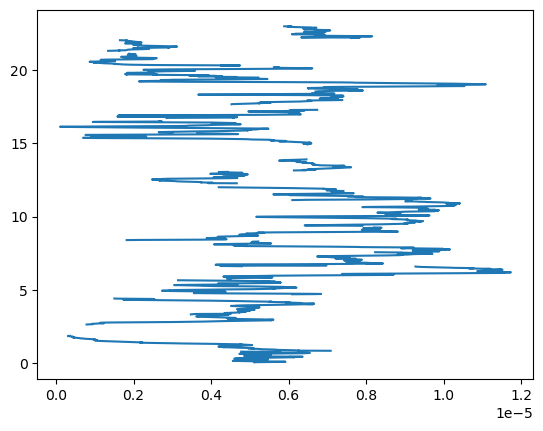

In [41]:
plt.plot(binned_DC_2201,binned_depth_2201,label='ALHIC2201')

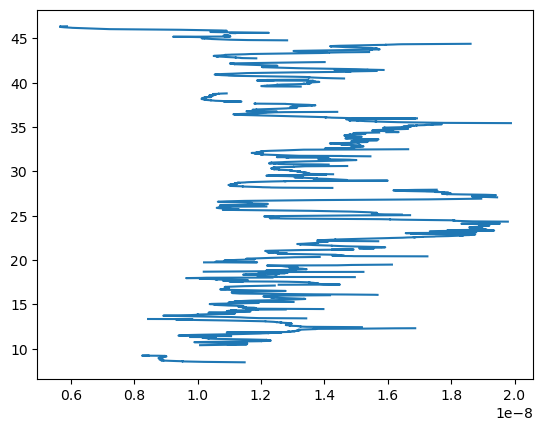

In [42]:
plt.plot(binned_AC_2302,binned_depth_2302,label='ALHIC2302')

In [35]:
binned_depth_2302

array([], dtype=float64)